# 필수 실행


## 구글드라이브 연결

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 필수 설치

In [67]:
!pip install category_encoders

## 필수 임포트

In [68]:
import os
import random
import numpy as np
import pandas as pd

# 인코더
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager as fm
import tqdm
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)

# seed값 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

## csv파일 불러오기


In [69]:
train_df = pd.read_csv('/content/drive/MyDrive/daegu/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/daegu/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/daegu/sample_submission.csv')
extra_train_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/countrywide_accident.csv')
light_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구보안등정보.csv',encoding='cp949')
child_area_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구어린이보호구역정보.csv',encoding='cp949')
parking_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구주차장정보.csv',encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구CCTV정보.csv',encoding='cp949')

## train/test data 합치기 및 컬럼정리


- 필요없다고 생각한 컬럼 정리

In [70]:
light_df = light_df.drop(columns=['보안등위치명','소재지도로명주소','위도','경도'])
child_area_df = child_area_df.drop(columns=['소재지도로명주소','위도','경도','데이터기준일자'])
parking_df = parking_df.drop(columns=['주차장관리번호','소재지도로명주소','위도','경도','데이터기준일자'])
cctv_df = cctv_df.drop(columns=['소재지도로명주소','위도','경도'])

In [71]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

- 보안등 정보

In [72]:
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

In [73]:
light_df = pd.get_dummies(light_df, columns=['설치형태'])

In [74]:
light_df['설치개수평균'] = light_df['설치개수']

light_ = light_df[['설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
                   '설치개수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
light__ = light_df[['설치개수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [75]:
light_.reset_index(inplace=True, drop=True)
light__.reset_index(inplace=True, drop=True)

- 어린이 보호구역

In [76]:
child_area_df['CCTV설치대수'].fillna(0, inplace=True)
child_area_df['CCTV설치한곳의수'] = 1
child_area_df['CCTV설치대수평균'] = child_area_df['CCTV설치대수']

In [77]:
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

In [78]:
child_area_df = pd.get_dummies(child_area_df, columns=['시설종류','관할경찰서명','CCTV설치여부'])

In [79]:
child_area_ = child_area_df[['시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y','CCTV설치한곳의수','CCTV설치대수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
child_area__ = child_area_df[['CCTV설치대수평균','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [80]:
child_area_.reset_index(inplace=True, drop=True)
child_area__.reset_index(inplace=True, drop=True)

- 주차장 정보

In [81]:
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df['주차구획수평균'] = parking_df['주차구획수']

parking_df = pd.get_dummies(parking_df, columns=['급지구분','결제방법','주차장구분','주차장유형'])


parking_df_ = parking_df[['급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외','주차구획수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
parking_df__ = parking_df[['주차구획수평균','주차기본요금','추가단위요금',
                           '1일주차권요금','월정기권요금','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

parking_df_.reset_index(inplace=True, drop=True)
parking_df__.reset_index(inplace=True, drop=True)

- cctv 정보

In [82]:
cctv_df['무인CCTV설치한곳의수'] = 1

In [83]:
cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소', '번지'])

In [84]:
cctv_df = pd.get_dummies(cctv_df, columns=['도로노선방향'])

In [85]:
cctv_ = cctv_df[['도로노선방향_1', '도로노선방향_2','도로노선방향_3',
                 '무인CCTV설치한곳의수','도시', '구', '동']].groupby(['도시', '구', '동']).sum().reset_index()
cctv__ = cctv_df[['설치연도','제한속도','도시', '구', '동']].groupby(['도시', '구', '동']).mean().round(2).reset_index()

In [86]:
cctv_.reset_index(inplace=True, drop=True)
cctv__.reset_index(inplace=True, drop=True)

- '사고일시' 분리

In [87]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

- '시군구' 분리

In [88]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

- '도로형태'분리

In [89]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)

test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)

- 추가정보들 일단 모두 merge하기

In [90]:
print(f'{light_df.shape}/{child_area_df.shape}/{parking_df.shape}/{cctv_df.shape}')

(71913, 9)/(640, 24)/(871, 39)/(1065, 20)


In [91]:
parking_df.columns

Index(['주차장명', '주차구획수', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '특기사항', '도시',
       '구', '동', '주차구획수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드',
       '결제방법_무료', '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금',
       '결제방법_현금+신용카드', '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영',
       '주차장유형_노상', '주차장유형_노외'],
      dtype='object')

In [92]:
train_df = train_df.drop(columns=['사고유형 - 세부분류', '법규위반',
                                  '가해운전자 차종', '가해운전자 성별','가해운전자 연령', '가해운전자 상해정도',
                                  '피해운전자 차종','피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도',
                                  '사망자수', '중상자수', '경상자수', '부상자수',])

In [93]:
train_df = pd.merge(train_df, light_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, light__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, light__, how='left', on=['도시', '구', '동'])

In [94]:
train_df = pd.merge(train_df, child_area_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, child_area_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area__, how='left', on=['도시', '구', '동'])

In [95]:
train_df = pd.merge(train_df, parking_df_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, parking_df_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df__, how='left', on=['도시', '구', '동'])

In [96]:
train_df = pd.merge(train_df, cctv_, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv__, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, cctv_, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, cctv__, how='left', on=['도시', '구', '동'])

# Model_25 [0.44190]

In [97]:
train = train_df.copy()
test = test_df.copy()

In [98]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [99]:
for i in ['노면상태','사고유형','도로형태2','요일','동']:

  _ant = train.groupby(['시간',i])['ECLO'].mean()
  train = pd.merge(train, _ant, how='left', on=['시간',i])
  train.rename(columns={'ECLO_x': 'ECLO','ECLO_y':'new'+ i}, inplace=True)

  test = pd.merge(test, _ant, how='left', on=['시간',i])


In [100]:
test.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',
       '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수',
       '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원',
       '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서',
       '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서',
       'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균',
       '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'ECLO_x', 'ECLO_y', 'ECLO_x', 'ECLO_y', 'ECLO'],
      dtype='object')

In [101]:
train.columns

Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주',
       '설치개수', '설치개수평균', '시설종류_어린이집', '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교',
       '시설종류_학원', '관할경찰서명_강북경찰서', '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서',
       '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서', '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서',
       '관할경찰서명_수성경찰서', 'CCTV설치여부_N', 'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수',
       'CCTV설치대수평균', '급지구분_1', '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료',
       '결제방법_신용카드', '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
       'new노면상태', 'new사고유형', 'new도로형태2', 'new요일', 'new동'],
      dtype='object')

In [102]:
test.columns = ['ID', '요일','기상상태', '도로형태', '노면상태', '사고유형','연', '월', '일', '시간', '도시', '구','동', '도로형태1',
       '도로형태2', '설치형태_건축물', '설치형태_전용주', '설치형태_한전주', '설치개수', '설치개수평균', '시설종류_어린이집',
       '시설종류_유치원', '시설종류_초등학교', '시설종류_특수학교', '시설종류_학원', '관할경찰서명_강북경찰서',
       '관할경찰서명_남부경찰서', '관할경찰서명_달성경찰서', '관할경찰서명_대구광역시 중부경찰서', '관할경찰서명_대구동부경찰서',
       '관할경찰서명_북부경찰서', '관할경찰서명_서부경찰서', '관할경찰서명_수성경찰서', 'CCTV설치여부_N',
       'CCTV설치여부_Y', 'CCTV설치한곳의수', 'CCTV설치대수', 'CCTV설치대수평균', '급지구분_1',
       '급지구분_2', '급지구분_3', '결제방법_교통카드', '결제방법_무료', '결제방법_신용카드',
       '결제방법_신용카드, 교통카드', '결제방법_카드', '결제방법_현금', '결제방법_현금+신용카드',
       '결제방법_현금, 신용카드', '결제방법_현금,카드', '주차장구분_공영', '주차장구분_민영', '주차장유형_노상',
       '주차장유형_노외', '주차구획수', '주차구획수평균', '주차기본요금', '추가단위요금', '1일주차권요금', '월정기권요금',
       '도로노선방향_1', '도로노선방향_2', '도로노선방향_3', '무인CCTV설치한곳의수', '설치연도', '제한속도',
        'new노면상태', 'new사고유형', 'new도로형태2', 'new요일','new동']

In [103]:
test_x = test[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_x = train[['노면상태', '사고유형', '도로형태2', '요일', '설치형태_건축물','설치형태_전용주'
                  ,'설치형태_한전주','시간','설치개수','설치개수평균','주차구획수',
                  '관할경찰서명_달성경찰서','CCTV설치여부_N','주차기본요금','설치연도', '제한속도']].copy()
train_y = train['ECLO'].copy()

## 시간 별 칼럼별 ECLO 평균

In [105]:
def time_range(time):
  if time >= 0 and time <= 7 :
    return 1
  elif time <= 12 :
    return 2
  elif time <= 18 :
    return 3
  else :
    return 4

train_x['time_range'] = train_x['시간'].apply(time_range)
test_x['time_range'] = test_x['시간'].apply(time_range)

In [106]:
def time_carBycar(data):
  if data['사고유형'] == '차대차':
    if data['time_range'] == 1:
      return 1
    elif data['time_range'] == 4:
      return 1
    else:
      return 2
  elif data['사고유형'] == '차대사람' and data['time_range'] == 3:
    return 0
  else:
    return 2


train_x['time_carBycar_data'] = train_x.apply(time_carBycar, axis = 1)
test_x['time_carBycar_data'] = test_x.apply(time_carBycar, axis = 1)
train_x.head()


,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data
0,건조,차대사람,기타,화요일,177.0,30.0,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,1,2
1,건조,차대사람,기타,화요일,0.0,0.0,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,1,2
2,건조,차대사람,기타,화요일,14.0,31.0,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,1,2
3,건조,차대차,기타,화요일,0.0,0.0,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,1,1
4,건조,차대차,기타,화요일,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,1,1


In [107]:
def time_road(data):
  if data['도로형태2'] == '터널':
    return 1
  elif data['도로형태2'] == '고가도로위':
    if data['time_range'] == 1 or data['time_range'] == 4:
      return 1
    else:
      return 0
  elif data['도로형태2'] == '주차장':
    return 2
  elif data['도로형태2'] == '미분류':
    return 2
  else :
    return 0

train_x['time_road_data'] = train_x.apply(time_road, axis = 1)
test_x['time_road_data'] = test_x.apply(time_road, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data
0,건조,차대사람,기타,화요일,177.0,30.0,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,1,2,0
1,건조,차대사람,기타,화요일,0.0,0.0,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,1,2,0
2,건조,차대사람,기타,화요일,14.0,31.0,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,1,2,0
3,건조,차대차,기타,화요일,0.0,0.0,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,1,1,0
4,건조,차대차,기타,화요일,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,1,1,0


## 요일별 칼럼별 ECLO 평균

- 요일별 시간

In [108]:
def sun_time_acci(data):
  if data['요일'] == '일요일':
    if data['time_range'] == 2 or data['time_range'] == 3:
      return 1
    else:
      return 0
  else:
    return 0

train_x['sun_timed_data'] = train_x.apply(sun_time_acci, axis = 1)
test_x['sun_timed_data'] = test_x.apply(sun_time_acci, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data
0,건조,차대사람,기타,화요일,177.0,30.0,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,1,2,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,1,2,0,0
3,건조,차대차,기타,화요일,0.0,0.0,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0
4,건조,차대차,기타,화요일,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,1,1,0,0


- 요일별 사고유형

In [109]:
def day_carBy(data):
  if data['사고유형'] == '차대차':
    if data['요일'] == '일요일':
      return 1
    elif data['요일'] == '토요일':
      return 1
    else :
      return 0
  elif data['사고유형'] == '차량단독':
    if data['요일'] == '수요일':
      return 2
    else:
      return 0
  elif data['사고유형'] == '차대사람' and data['요일'] == '목요일':
    return 2
  else:
    return 0

train_x['day_carBy_data'] = train_x.apply(day_carBy, axis = 1)
test_x['day_carBy_data'] = test_x.apply(day_carBy, axis = 1)
train_x.head()

,노면상태,사고유형,도로형태2,요일,설치형태_건축물,설치형태_전용주,설치형태_한전주,시간,설치개수,설치개수평균,주차구획수,관할경찰서명_달성경찰서,CCTV설치여부_N,주차기본요금,설치연도,제한속도,time_range,time_carBycar_data,time_road_data,sun_timed_data,day_carBy_data
0,건조,차대사람,기타,화요일,177.0,30.0,135.0,0,391.0,1.00,500.0,0.0,0.0,1136.36,2013.00,8.0,1,2,0,0,0
1,건조,차대사람,기타,화요일,0.0,0.0,0.0,0,932.0,1.00,114.0,0.0,0.0,150.00,2015.33,17.5,1,2,0,0,0
2,건조,차대사람,기타,화요일,14.0,31.0,425.0,1,473.0,1.00,0.0,0.0,0.0,0.00,2018.25,55.0,1,2,0,0,0
3,건조,차대차,기타,화요일,0.0,0.0,0.0,2,534.0,1.00,374.0,0.0,2.0,71.43,2018.30,38.0,1,1,0,0,0
4,건조,차대차,기타,화요일,540.0,57.0,1396.0,4,2057.0,1.03,63.0,0.0,0.0,600.00,2018.25,40.0,1,1,0,0,0


In [110]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [111]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

y_train = np.log(train_y)

In [112]:
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

In [113]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 43)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 43)


In [114]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(),LGBMRegressor(),XGBRegressor(),GradientBoostingRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor','LGBMRegressor','XGBRegressor','GradientBoostingRegressor']
rmsle=[]
submission = submission_df.copy()
for model in range(len(models)):
  clf=models[model]
  clf.fit(X_train,y_train)
  test_pred=clf.predict(X_val)
  y_pred = np.exp(test_pred)
  y_val1 = np.exp(y_val)

  rmsle.append(np.sqrt(mean_squared_log_error(y_pred,y_val1)))
  print(f"Modelling Algo:{model_names[model]},RMSLE:{rmsle[model]}")

  pred = clf.predict(X_test_eng)
  pred_1 = np.exp(pred)
  submission[model] = pred_1

Modelling Algo:RandomForestRegressor,RMSLE:0.49700305191019734
Modelling Algo:AdaBoostRegressor,RMSLE:0.44984422937366836
Modelling Algo:BaggingRegressor,RMSLE:0.5101534181361077
Modelling Algo:SVR,RMSLE:0.48217902654532735
Modelling Algo:KNeighborsRegressor,RMSLE:0.48758497552865865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 39
[LightGBM] [Info] Start training from score 1.383856
Modelling Algo:LGBMRegressor,RMSLE:0.4473801018534184
Modelling Algo:XGBRegressor,RMSLE:0.4564186860455326
Modelling Algo:GradientBoostingRegressor,RMSLE:0.4460579837432016


RandomForestRegressor


<Axes: xlabel='0', ylabel='Count'>

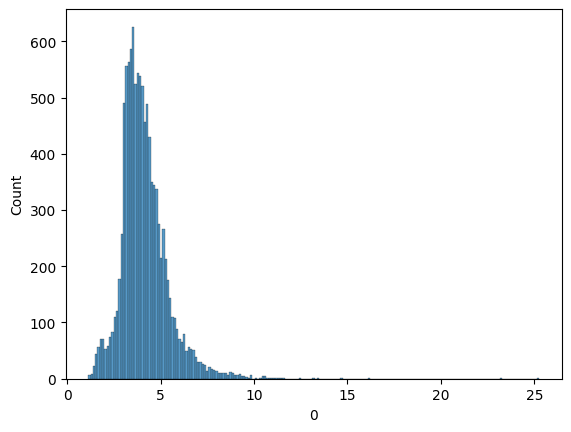

In [ ]:
print('RandomForestRegressor')
sns.histplot(submission[0])

AdaBoostRegressor


<Axes: xlabel='1', ylabel='Count'>

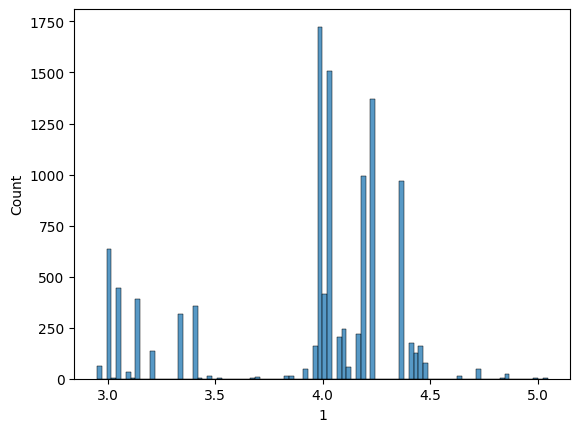

In [ ]:
print('AdaBoostRegressor')
sns.histplot(submission[1])

BaggingRegressor


<Axes: xlabel='2', ylabel='Count'>

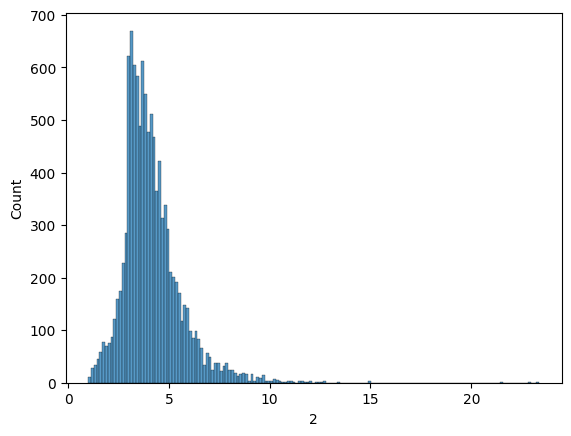

In [ ]:
print('BaggingRegressor')
sns.histplot(submission[2])

SVR


<Axes: xlabel='3', ylabel='Count'>

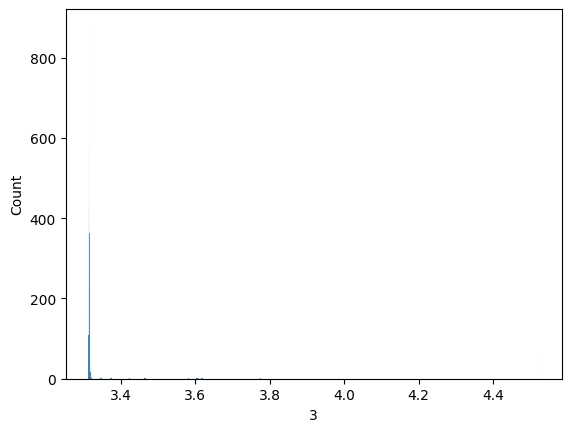

In [ ]:
print('SVR')
sns.histplot(submission[3])

KNeighborsRegressor


<Axes: xlabel='4', ylabel='Count'>

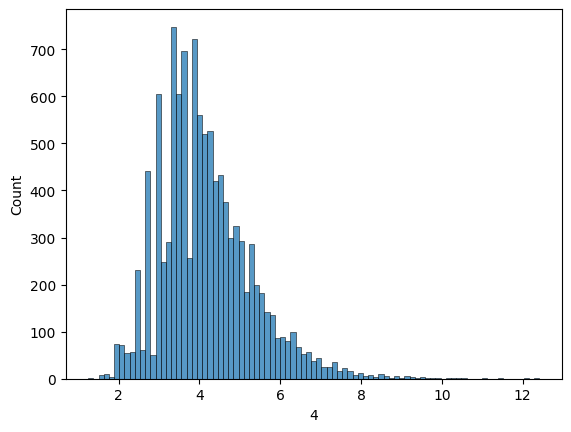

In [ ]:
print('KNeighborsRegressor')
sns.histplot(submission[4])

LGBMRegressor


<Axes: xlabel='5', ylabel='Count'>

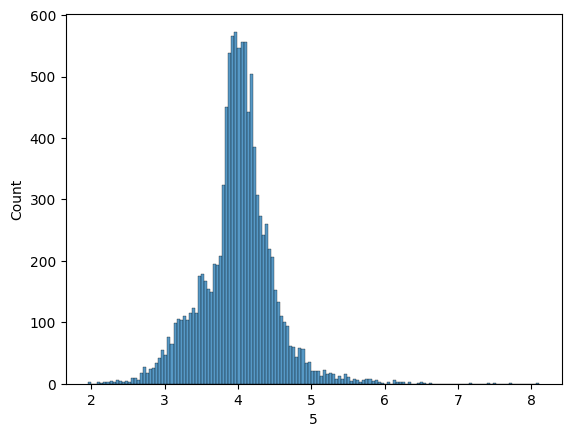

In [ ]:
print('LGBMRegressor')
sns.histplot(submission[5])

XGBRegressor


<Axes: xlabel='6', ylabel='Count'>

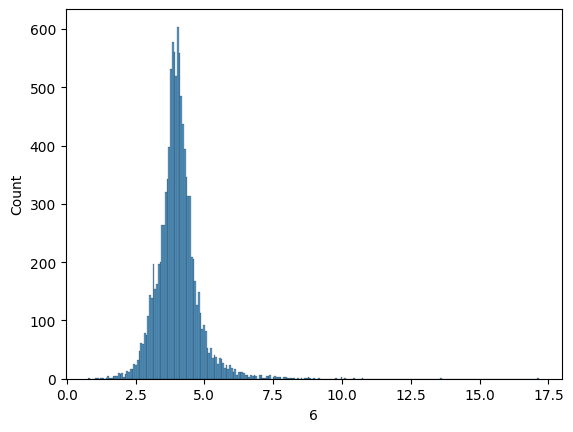

In [ ]:
print('XGBRegressor')
sns.histplot(submission[6])

GradientBoostingRegressor


<Axes: xlabel='7', ylabel='Count'>

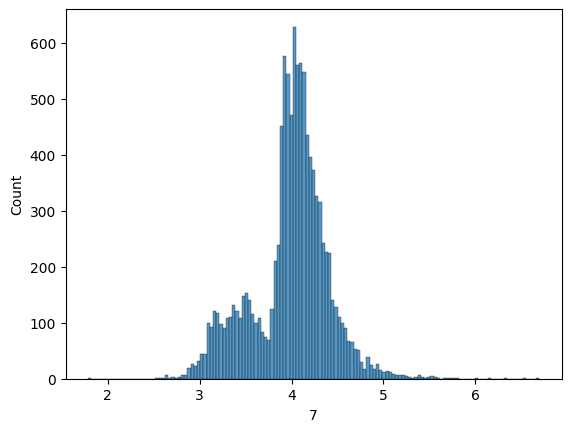

In [ ]:
print('GradientBoostingRegressor')
sns.histplot(submission[7])

In [ ]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()


class LGBObjective:
    def __init__(self,x_train,y_train,seed, scoring):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        self.scoring = scoring
        self.num_folds=5 # 일반적으로는 5
        self.cv = KFold(n_splits=self.num_folds,shuffle=True,random_state=self.seed)
    def __call__(self,trial):
        hp = {
            "max_depth" : trial.suggest_int("max_depth",5,15),
            "n_estimators" : trial.suggest_int("n_estimators",500,10000),
            "learning_rate" : trial.suggest_loguniform("learning_rate",0.001,0.3),

            "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0)
        }
        model = LGBMRegressor(random_state=self.seed, verbose= -1,**hp)
        scores = cross_val_score(model,self.x_train,self.y_train, cv = self.cv , scoring=self.scoring)
        return np.mean(scores)


sampler = TPESampler(seed=args.SEED) # 대체모델 부분

# 스터디 객체
study = optuna.create_study(
    direction = "minimize", # maximize or minimize
    sampler = sampler
)

objective = LGBObjective(train_features, y_count, args.SEED, rmsle_scorer)
study.optimize(objective,n_trials=10)

print("Best Score:", study.best_value) # 최고점수
print("Best hp", study.best_params) # 최고점수의 하이퍼파라미터조합

In [120]:
# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', RandomForestRegressor()),
    ('abr', AdaBoostRegressor()),
    ('br' , BaggingRegressor()),
    ('svr' ,  SVR()),
    ('knr' , KNeighborsRegressor()),
    ('lgbm', LGBMRegressor()),
    ('xgb', XGBRegressor()),
    ('gb', GradientBoostingRegressor())
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 39
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 39
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [121]:
print(np.sqrt(mean_squared_log_error(y_train1,y_train_pred1)))
print(np.sqrt(mean_squared_log_error(y_val1, y_val_pred1)))

0.4392187968679945
0.4460024771762415


In [123]:
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.37044573, 1.26724878, 1.50914279, ..., 1.45121647, 1.47249161,
       1.49562812])

In [124]:
y_pred = np.exp(y_pred1)
y_pred

array([3.93710519, 3.55106935, 4.52285211, ..., 4.26830364, 4.36008526,
       4.46213845])

In [125]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.937105
1,ACCIDENT_39610,3.551069
2,ACCIDENT_39611,4.522852
3,ACCIDENT_39612,4.078563
4,ACCIDENT_39613,4.362894


<Axes: ylabel='Count'>

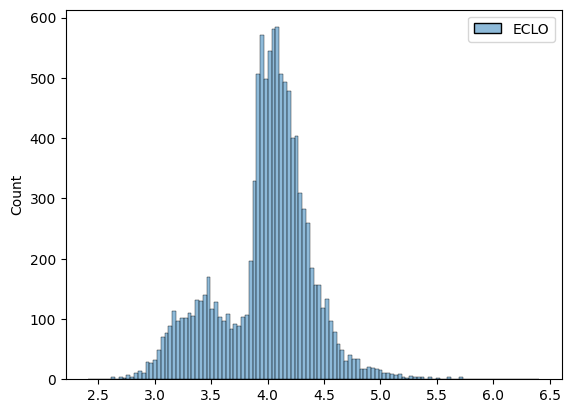

In [127]:
sns.histplot(submission_df)

In [126]:
submission_df.to_csv('/content/drive/MyDrive/[Stacking + model ]최고점수조합.csv', index=False)